## Instalación y verificación de dependencias
Esta celda prepara el entorno de explicabilidad:
- Instalar `captum`, `lime`, `shap` y `scikit-image`.
- Intentar varias estrategias de instalación para `pytorch-grad-cam` (estándar, versión fijada, sin caché/upgrade y desde GitHub).
- Registrar incidencias de instalación y mostrar pistas de diagnóstico cuando falle alguna estrategia.
- Exportar la variable `GRAD_CAM_AVAILABLE` para indicar disponibilidad de Grad-CAM en el resto del notebook.
- Ejecutar esta celda solo una vez por entorno; reutilizar instalaciones en sesiones posteriores.

In [1]:
# Instalar y verificar librerías (ejecutar solo una vez)
import sys, subprocess, importlib, textwrap, os
from subprocess import CalledProcessError

# Implementar varias estrategias para instalar pytorch-grad-cam.
# Si ninguna funciona, desactivar secciones CAM con un stub para poder continuar el análisis.

packages = [
    ("captum", "captum"),
    ("lime", "lime"),
    ("shap", "shap"),
    ("scikit-image", "skimage")
]

GRAD_CAM_IMPORT = "pytorch_grad_cam"
GRAD_CAM_PIP = "pytorch-grad-cam"
GRAD_CAM_PINNED = "pytorch-grad-cam==1.5.0"  # versión estable conocida
GRAD_CAM_GIT = "git+https://github.com/jacobgil/pytorch-grad-cam.git"


def run(cmd):
    print("$", " ".join(cmd))
    subprocess.check_call(cmd)


def try_import(name):
    try:
        importlib.import_module(name)
        return True
    except ImportError:
        return False


def install_strategy(pkg_spec):
    try:
        run([sys.executable, "-m", "pip", "install", pkg_spec])
        return True
    except CalledProcessError as e:
        print(f"✖ Falló: {pkg_spec} (code={e.returncode})")
        return False

failures = []
# Instalar primero paquetes auxiliares
for pip_name, import_name in packages:
    if try_import(import_name):
        print(f"✔ {pip_name} ya instalado")
        continue
    print(f"→ Instalando {pip_name}...")
    ok = install_strategy(pip_name)
    if ok and try_import(import_name):
        print(f"✔ {pip_name} instalado correctamente")
    else:
        failures.append(pip_name)

# Gestionar caso especial para pytorch-grad-cam
cam_installed = try_import(GRAD_CAM_IMPORT)
if not cam_installed:
    print("→ Intento 1: instalación estándar pytorch-grad-cam")
    if install_strategy(GRAD_CAM_PIP) and try_import(GRAD_CAM_IMPORT):
        cam_installed = True
        print("✔ pytorch-grad-cam instalado (estándar)")

if not cam_installed:
    print("→ Intento 2: versión fijada", GRAD_CAM_PINNED)
    if install_strategy(GRAD_CAM_PINNED) and try_import(GRAD_CAM_IMPORT):
        cam_installed = True
        print("✔ pytorch-grad-cam instalado (pin 1.5.0)")

if not cam_installed:
    print("→ Intento 3: instalación sin caché + upgrade")
    try:
        run([sys.executable, "-m", "pip", "install", "--no-cache-dir", "--upgrade", GRAD_CAM_PIP])
        if try_import(GRAD_CAM_IMPORT):
            cam_installed = True
            print("✔ pytorch-grad-cam instalado (no-cache)")
    except CalledProcessError as e:
        print("✖ Falló no-cache", e.returncode)

if not cam_installed:
    print("→ Intento 4: instalación desde GitHub master")
    if install_strategy(GRAD_CAM_GIT) and try_import(GRAD_CAM_IMPORT):
        cam_installed = True
        print("✔ pytorch-grad-cam instalado (git)")

if not cam_installed:
    failures.append(GRAD_CAM_PIP)

if failures:
    print("\nNotas técnicas para instalación (registro):")
    for f in failures:
        print(" - Paquete con incidencia:", f)
    print(textwrap.dedent(f"""
Pistas usadas durante diagnóstico:
1. Actualizar pip y wheel:
   py -m pip install --upgrade pip setuptools wheel
2. Verificar versión de torch compatible con Python {sys.version.split()[0]}:
   py -m pip install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cpu
3. Confirmar que 'import torch' funciona antes de CAM.
4. Probar pin alternativo: pytorch-grad-cam==1.4.1
5. Entornos corporativos: configurar HTTP_PROXY/HTTPS_PROXY si aplica.
6. Último recurso: clonar repo y usar instalación editable:
   py -m pip install -e .
"""))
    print("Continuo con stubs para secciones CAM no disponibles.")
else:
    print("\nInstalación verificada de dependencias requeridas.")

# Definir flag global para el notebook
os.environ['GRAD_CAM_AVAILABLE'] = '1' if cam_installed else '0'

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✔ captum ya instalado
✔ lime ya instalado
✔ shap ya instalado
✔ scikit-image ya instalado
✔ shap ya instalado
✔ scikit-image ya instalado

Instalación verificada de dependencias requeridas.

Instalación verificada de dependencias requeridas.


## Imports base y disponibilidad de Grad-CAM
Esta celda realiza las siguientes acciones:
- Importar módulos base (`torch`, `numpy`, `matplotlib`, `PIL`, `torchvision`) y componentes de Captum para mapas de atribución.
- Comprobar disponibilidad de `pytorch-grad-cam`; si no está disponible, definir stubs de reemplazo para mantener el flujo del notebook.
- Importar utilidades complementarias (`skimage.segmentation`, `lime_image`, `shap`).
- Informar el dispositivo activo (CPU/GPU) que utilizará el modelo.

In [2]:
# Importar módulos base y comprobar disponibilidad de Grad-CAM
import os, torch, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
import torchvision.models as models
from captum.attr import (
    IntegratedGradients, Saliency, GuidedBackprop, NoiseTunnel, Occlusion, DeepLift
)

GRAD_CAM_AVAILABLE = os.environ.get('GRAD_CAM_AVAILABLE','0') == '1'
if GRAD_CAM_AVAILABLE:
    try:
        from pytorch_grad_cam import (GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM, LayerCAM)
        from pytorch_grad_cam.utils.image import show_cam_on_image
        print('✔ pytorch-grad-cam importado correctamente')
    except Exception as e:
        print('✖ Error inesperado importando pytorch-grad-cam:', e)
        GRAD_CAM_AVAILABLE = False
else:
    print('⚠ pytorch-grad-cam no disponible; habilito stubs para continuar el flujo.')
    def _stub_cam(*args, **kwargs):
        raise RuntimeError('pytorch-grad-cam ausente. Consultar la primera celda para detalles de instalación que utilicé.')
    GradCAM = GradCAMPlusPlus = ScoreCAM = EigenCAM = LayerCAM = _stub_cam
    def show_cam_on_image(img, cam, use_rgb=True):
        return (img*255).astype(np.uint8)

from skimage.segmentation import slic
from lime import lime_image
import shap

print('Device:', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

✔ pytorch-grad-cam importado correctamente
Device: cuda
Device: cuda


## Definición del modelo y carga de pesos
Esta celda define y prepara el modelo de segmentación:
- Definir `UNetResNet50` con encoder ResNet-50 preentrenado y decoder con `ConvTranspose2d`/`Upsample`.
- Mover el modelo al dispositivo activo (CPU/GPU) y establecer modo evaluación (`eval`).
- Localizar el archivo de pesos `unet_resnet50.pth` en la raíz del proyecto y cargarlo si existe (con `map_location`).
- Informar si se cargaron pesos o si el modelo permanece sin entrenar, y mostrar el flag de disponibilidad de Grad-CAM.

In [3]:
# Definir el modelo (idéntico al notebook principal) y configurar fallback si CAM ausente
import torch
from torch import nn
import torchvision.models as models
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class UNetResNet50(nn.Module):
    def __init__(self, in_channels=3, out_classes=6):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 2, 2), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, 2), nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, out_classes, 1)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = UNetResNet50().to(device)

# Buscar pesos en el directorio padre
notebook_dir = Path.cwd()
if 'explicabilidad_notebooks' in str(notebook_dir):
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir
model_path = project_root / 'unet_resnet50.pth'

if model_path.exists():
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f'Modelo cargado desde {model_path}')
else:
    print(f'Pesos no encontrados en {model_path}. Usando modelo sin entrenar.')

model.eval()
print('Modelo listo. Grad-CAM disponible?' , os.environ.get('GRAD_CAM_AVAILABLE','0'))

Modelo cargado desde c:\Users\david\Documents\PAgentes\unet_resnet50.pth
Modelo listo. Grad-CAM disponible? 1


## Dataset, mapeo macronutrientes y transformaciones
Esta celda construye el conjunto de datos y utilidades asociadas:
- Definir `MacronutrientDataset` para cargar imágenes y máscaras, y aplicar `albumentations`/`ToTensorV2`.
- Reconstruir `id2macro` a partir de `ingredients.csv` mapeando ingredientes a macro-clases (background, proteins, carbohydrates, fats, vegetables, other).
- Configurar transformaciones (redimensionar a 256×256, normalizar y convertir a tensor).
- Inicializar el dataset con rutas a `images/` y `masks/`, y reportar su tamaño.
- Validar la existencia del CSV y lanzar error descriptivo si falta.

In [4]:
# Definir dataset mínimo para cargar una muestra (reusar mapeo macro)
import albumentations as A
from albumentations.pytorch import ToTensorV2

class MacronutrientDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, id2macro, transform=None):
        self.imgs = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.id2macro = id2macro
        self.transform = transform
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = np.array(Image.open(os.path.join(self.images_dir, self.imgs[idx])).convert('RGB'))
        mask = np.array(Image.open(os.path.join(self.masks_dir, self.masks[idx])))
        macro_mask = np.zeros_like(mask)
        for cid, mid in self.id2macro.items(): macro_mask[mask == cid] = mid
        if self.transform:
            aug = self.transform(image=img, mask=macro_mask)
            img, macro_mask = aug['image'], aug['mask']
        # Verificar tipo de máscara tras ToTensorV2
        if not isinstance(macro_mask, torch.Tensor):
            macro_mask = torch.from_numpy(macro_mask).long()
        else:
            macro_mask = macro_mask.long()
        return img, macro_mask

# Reconstruir id2macro desde ingredients.csv (buscar en directorio padre)
import pandas as pd
from pathlib import Path

# Determinar rutas del notebook y del proyecto
notebook_dir = Path.cwd()
if 'explicabilidad_notebooks' in str(notebook_dir):
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

csv_path = project_root / 'ingredients.csv'
images_dir = project_root / 'images'
masks_dir = project_root / 'masks'

if not csv_path.exists():
    raise FileNotFoundError(f"No se encuentra {csv_path}. Verifica que estés ejecutando desde la carpeta correcta.")

ing = pd.read_csv(csv_path)
id2label = dict(zip(ing.id, ing.ingredient))
macro_map = {
 'background': {'background'},
 'protein': {'egg','steak','pork','chicken duck','sausage','fried meat','lamb','tofu','crab','fish','shrimp','shellfish','soy','milk','king oyster mushroom','shiitake','enoki mushroom','oyster mushroom','white button mushroom'},
 'carbohydrate': {'bread','rice','pasta','noodles','cake','biscuit','egg tart','pizza','popcorn','wonton dumplings','hanamaki baozi','pie','corn','french fries','red beans','pudding','ice cream','candy','apple','banana','strawberry','cherry','blueberry','raspberry','mango','peach','lemon','pear','fig','pineapple','grape','kiwi','melon','orange','watermelon','date','apricot','dried cranberries'},
 'fat': {'cheese butter','almond','cashew','walnut','peanut','chocolate','avocado','olives'},
 'vegetable': {'eggplant','potato','garlic','cauliflower','tomato','kelp','seaweed','spring onion','rape','ginger','okra','lettuce','pumpkin','cucumber','white radish','carrot','asparagus','bamboo shoots','broccoli','celery stick','cilantro mint','snow peas','cabbage','bean sprouts','onion','pepper','green beans','French beans','salad'},
 'other': {'coffee','tea','wine','soup','hamburg','sauce','other ingredients','juice','milkshake'}
}
macro_names = ['background','proteins','carbohydrates','fats','vegetables','other']
# Construir id2macro
id2macro = {}
for idx,lab in id2label.items():
    mc = 0
    for k in macro_map:
        if lab.lower() in {x.lower() for x in macro_map[k]}:
            mc = list(macro_map.keys()).index(k)
            break
    id2macro[idx]=mc

transform = A.Compose([A.Resize(256,256), A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)), ToTensorV2()])
dataset = MacronutrientDataset(str(images_dir), str(masks_dir), id2macro, transform)
print(f'Dataset tamaño: {len(dataset)} (usando {project_root})')

Dataset tamaño: 4983 (usando c:\Users\david\Documents\PAgentes)


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Utilidades de muestreo y selección de imagen
Esta celda define utilidades y selecciona la muestra de trabajo:
- Definir `get_sample`, `denormalize` y `save_fig` para facilitar lectura, visualización y guardado de resultados.
- Determinar el índice de inicio de validación y decidir si utilizar una imagen externa (`pasta.jpg`) o una imagen del conjunto de validación.
- Aplicar las mismas transformaciones a la imagen externa y crear una máscara dummy cuando no haya ground-truth disponible.
- Preparar `sample_img` (tensor 3×H×W) y `sample_mask` para su uso en las celdas de explicabilidad posteriores.

In [5]:
# Definir utilidades: selección de muestra, desnormalizar y guardar
def get_sample(index=0):
    img, mask = dataset[index]
    return img.to(device), mask.to(device)

def denormalize(t):
    return (t * 0.5 + 0.5).clamp(0,1)

def save_fig(fname):
    # Guardar figuras en el directorio raíz del proyecto
    out_dir = project_root / 'explicabilidad_resultados'
    out_dir.mkdir(exist_ok=True)
    plt.savefig(str(out_dir / fname), dpi=300, bbox_inches='tight')

# Utilizar una imagen del conjunto de validación o una imagen externa
train_size = int(0.8 * len(dataset))  # 80% entrenamiento
val_start_idx = train_size

# Configurar imagen externa
USE_EXTERNAL_IMAGE = True
EXTERNAL_IMAGE_NAME = 'pasta.jpg'
external_path = project_root / EXTERNAL_IMAGE_NAME

if USE_EXTERNAL_IMAGE and external_path.exists():
    # Cargar imagen externa y aplicar el mismo transform (sin máscara real, usar dummy)
    ext_np = np.array(Image.open(external_path).convert('RGB'))
    dummy_mask = np.zeros((ext_np.shape[0], ext_np.shape[1]), dtype=np.uint8)
    aug = transform(image=ext_np, mask=dummy_mask)
    sample_img = aug['image'].to(device)
    sample_mask = torch.zeros((sample_img.shape[1], sample_img.shape[2]), dtype=torch.long, device=device)
    print(f'✓ Imagen externa cargada: {EXTERNAL_IMAGE_NAME} -> tensor {sample_img.shape}')
    print('  (No hay máscara ground-truth; uso la predicción del modelo para CAM)')
else:
    # Usar una imagen de validación del dataset
    sample_idx = val_start_idx + 200
    sample_img, sample_mask = get_sample(sample_idx)
    print(f'✓ Muestra dataset -> shape: {sample_img.shape}')
    print(f'✓ Imagen #{sample_idx} del conjunto de VALIDACIÓN')
    print(f'  (El modelo entrenó con imágenes 0-{train_size-1}; esta es no vista)')

✓ Imagen externa cargada: pasta.jpg -> tensor torch.Size([3, 256, 256])
  (No hay máscara ground-truth; uso la predicción del modelo para CAM)


## Grad-CAM (Principal)
Genero el mapa de calor para una macro-clase objetivo usando la última capa del encoder (mayor contexto).

Si `pytorch-grad-cam` no está disponible, dejo habilitado un stub y documenté en la primera celda los pasos de instalación y diagnóstico que utilicé.

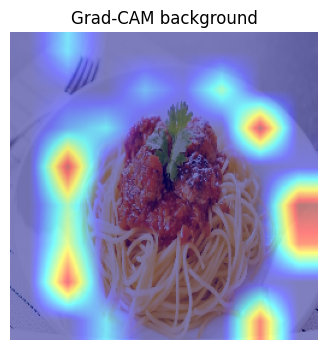

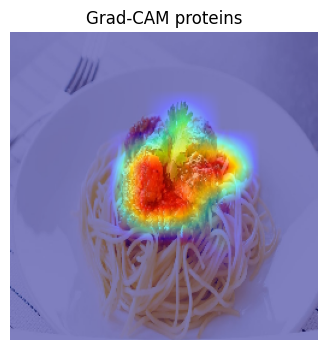

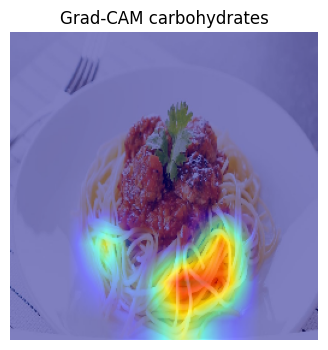

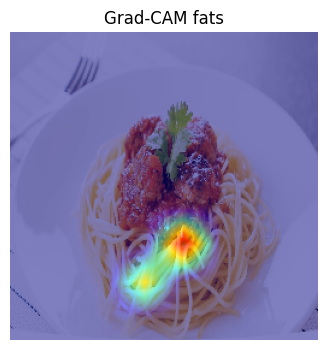

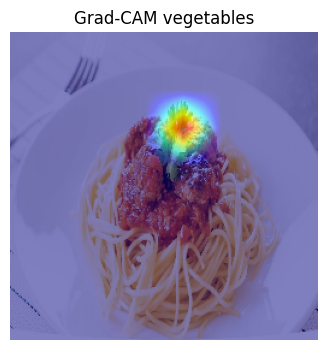

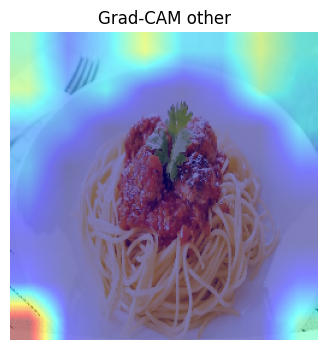

Grad-CAM por clase guardado.

INTERPRETACIÓN DE RESULTADOS:
Se evidencian mapas de calor Grad-CAM para cada macro-clase, donde las regiones
rojas/amarillas indican áreas de alta activación que el modelo considera relevantes
para clasificar esa categoría específica. Esto ocurre porque Grad-CAM calcula el
gradiente de la clase objetivo respecto a las activaciones de la última capa
convolucional del encoder, identificando qué regiones espaciales contribuyen más
a la predicción de cada macro-nutriente. Las clases ausentes en la imagen muestran
mapas difusos o uniformes, mientras que las clases presentes exhiben activaciones
concentradas en las regiones correspondientes a esos alimentos.


In [6]:
target_layers = [model.encoder[-1]]  # Seleccionar capa final del encoder

from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

def gradcam_for_class(img_tensor, class_idx, method='gradcam'):
    img_batch = img_tensor.unsqueeze(0)
    
    if method == 'gradcam': cam_cls = GradCAM
    elif method == 'gradcam++': cam_cls = GradCAMPlusPlus
    elif method == 'scorecam': cam_cls = ScoreCAM
    elif method == 'eigencam': cam_cls = EigenCAM
    elif method == 'layercam': cam_cls = LayerCAM
    else: raise ValueError('Método no soportado')
    
    cam = cam_cls(model=model, target_layers=target_layers)
    
    # Obtener la predicción del modelo para generar una máscara de la clase
    with torch.no_grad():
        output = model(img_batch)  # [1, 6, 256, 256]
        pred_mask = output.argmax(dim=1)[0]  # [256, 256]
    
    # Crear máscara binaria donde el modelo predice la clase objetivo
    # Si la clase no está presente, usar máscara uniforme pequeña
    class_mask = (pred_mask == class_idx).float().cpu().numpy()
    if class_mask.sum() < 10:  # Si hay muy pocos píxeles, usar máscara completa
        class_mask = np.ones_like(class_mask) * 0.1
    
    targets = [SemanticSegmentationTarget(class_idx, class_mask)]
    
    grayscale_cam = cam(input_tensor=img_batch, targets=targets)[0]  # [H,W]
    
    # Superponer (overlay)
    img_np = denormalize(img_tensor).permute(1,2,0).cpu().numpy()
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    return cam_image, grayscale_cam

# Ejecutar ejemplo para cada macro-clase
macro_examples = {}
for cidx, cname in enumerate(['background','proteins','carbohydrates','fats','vegetables','other']):
    vis, raw = gradcam_for_class(sample_img, cidx, method='gradcam')
    plt.figure(figsize=(4,4))
    plt.imshow(vis)
    plt.title(f'Grad-CAM {cname}')
    plt.axis('off')
    save_fig(f'gradcam_{cname}.png')
    plt.show()
    macro_examples[cname] = raw
print('Grad-CAM por clase guardado.')

print('\n' + '='*80)
print('INTERPRETACIÓN DE RESULTADOS:')
print('='*80)
print('Se evidencian mapas de calor Grad-CAM para cada macro-clase, donde las regiones')
print('rojas/amarillas indican áreas de alta activación que el modelo considera relevantes')
print('para clasificar esa categoría específica. Esto ocurre porque Grad-CAM calcula el')
print('gradiente de la clase objetivo respecto a las activaciones de la última capa')
print('convolucional del encoder, identificando qué regiones espaciales contribuyen más')
print('a la predicción de cada macro-nutriente. Las clases ausentes en la imagen muestran')
print('mapas difusos o uniformes, mientras que las clases presentes exhiben activaciones')
print('concentradas en las regiones correspondientes a esos alimentos.')
print('='*80)

### Grad-CAM Avanzado
A continuación se profundiza el análisis:
- Comparación multi-capa (layer1, layer2, layer3, layer4) para observar granularidad vs. semántica.
- Métricas de fidelidad: curvas Insertion / Deletion (revelando u ocultando píxeles ordenados por importancia CAM).
- Sanity check de randomización (Adebayo et al.): re-inicializar pesos y ver degradación del mapa.
- Promedio de CAM por clase sobre varias muestras para patrones globales.
- Funciones utilitarias extra para guardado y normalización.


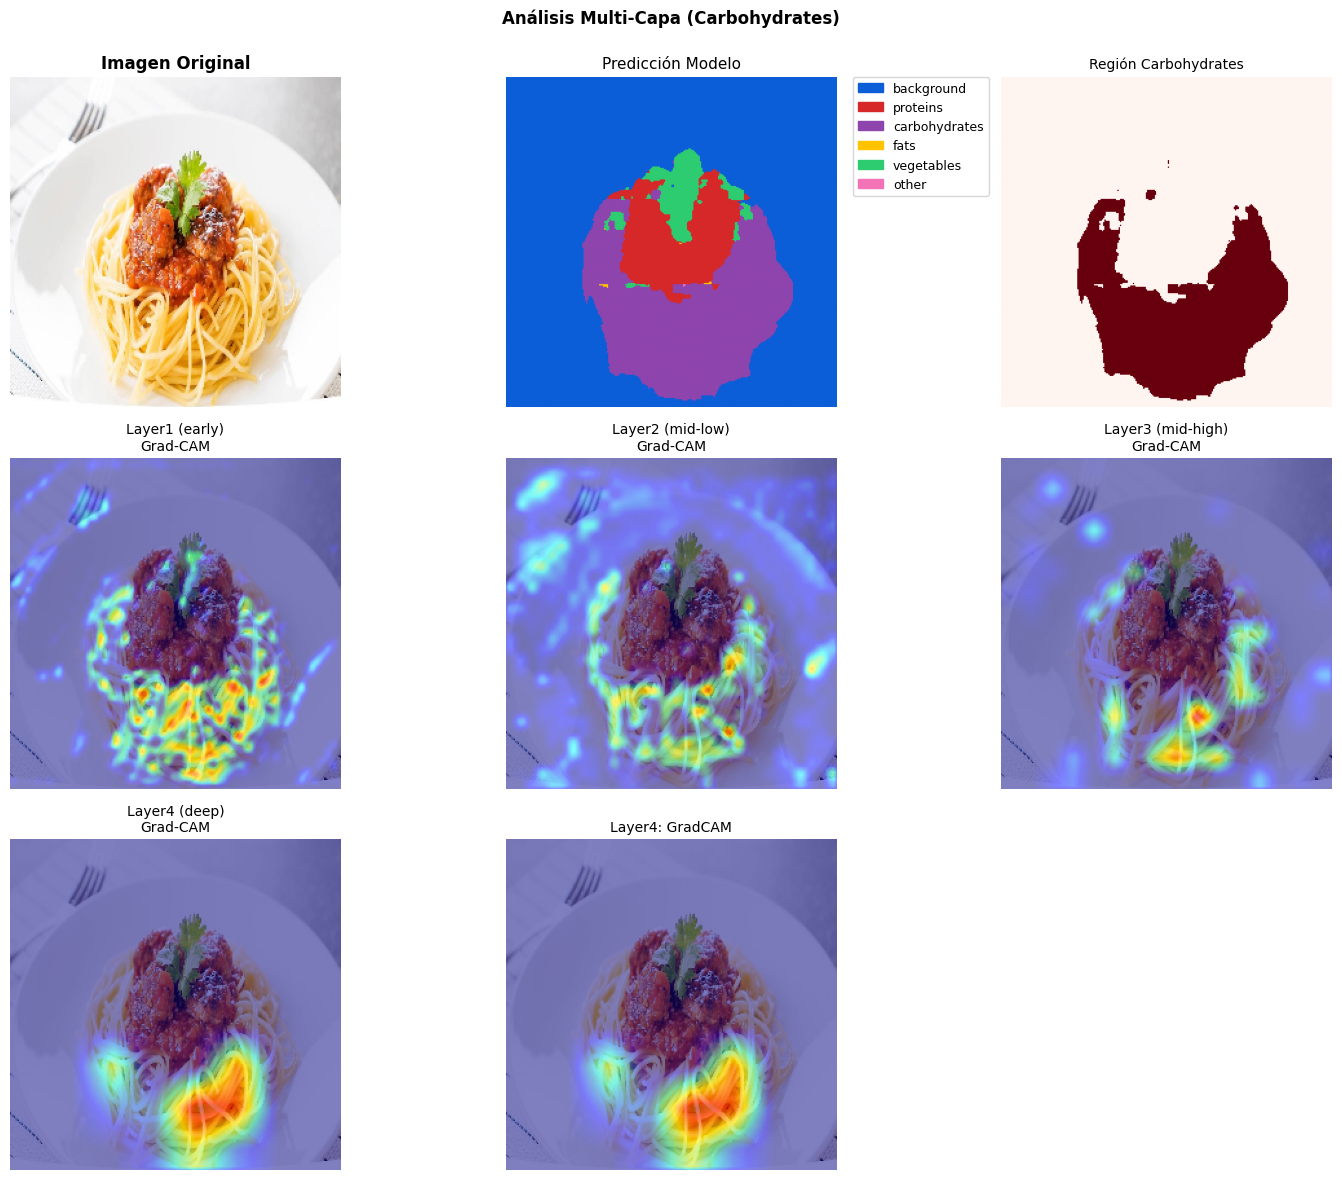


INTERPRETACIÓN:
Capas tempranas → detalles locales; Capas profundas → contexto global.
Comparación con GradCAM++ eliminada; se enfatiza Grad-CAM estándar.

INTERPRETACIÓN DE RESULTADOS:
Se evidencia una progresión jerárquica en los mapas Grad-CAM a través de las capas
del encoder ResNet-50. Layer1 (early) muestra activaciones finas y granulares que
capturan detalles de textura y bordes locales. A medida que avanzamos hacia capas
más profundas (Layer2-3), las activaciones se vuelven más abstractas y semánticas.
Layer4 (deep) presenta el contexto global más completo, integrando características
de alto nivel para identificar la región de carbohidratos. Este comportamiento ocurre
porque las redes convolucionales aprenden representaciones jerárquicas: capas
iniciales detectan patrones básicos (bordes, texturas), mientras que capas profundas
combinan estas características para reconocer objetos completos y contextos espaciales.


In [7]:
# Comparar Grad-CAM multi-capa (GradCAM++ removido)
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

multi_layers = [model.encoder[4], model.encoder[5], model.encoder[6], model.encoder[7]]  # layer1..layer4
class_to_visualize = 2  # carbohydrates (pasta)

class_names = ['background','proteins','carbohydrates','fats','vegetables','other']
class_colors = ['#0B5ED7', '#D62828', '#8E44AD', '#FFC300', '#2ECC71', '#F472B6']
cmap_custom = ListedColormap(class_colors)
legend_patches = [mpatches.Patch(color=class_colors[i], label=class_names[i]) for i in range(len(class_names))]

def _build_class_mask(output, class_idx, min_pixels=15):
    with torch.no_grad():
        probs = torch.softmax(output, dim=1)[0, class_idx]
        pred_mask = (output.argmax(dim=1)[0] == class_idx)
    binary_mask = pred_mask.float().cpu().numpy()
    prob_mask = probs.cpu().numpy()
    pixel_count = float(binary_mask.sum())
    if pixel_count > 0:
        prob_mean = float(prob_mask[binary_mask.astype(bool)].mean())
    else:
        prob_mean = float(prob_mask.mean())
    return binary_mask, prob_mask, pixel_count, prob_mean

def _choose_target_mask(binary_mask_np, prob_mask_np, pixel_count, prob_mean, min_pixels=15, prob_threshold=0.35, topk_frac=0.03):
    if pixel_count >= min_pixels:
        return binary_mask_np
    if prob_mean >= prob_threshold:
        norm = (prob_mask_np - prob_mask_np.min()) / (prob_mask_np.max() - prob_mask_np.min() + 1e-8)
        return norm
    flat = prob_mask_np.flatten()
    k = max(1, int(len(flat) * topk_frac))
    idxs = np.argpartition(flat, -k)[-k:]
    mask = np.zeros_like(flat)
    mask[idxs] = 1.0
    mask = mask.reshape(prob_mask_np.shape)
    return mask.astype(np.float32)

def _smooth_map(cam_t, kernel=5):
    return F.avg_pool2d(cam_t, kernel_size=kernel, stride=1, padding=kernel//2)

def compute_cam(layer, method, img_tensor, class_idx, smooth=True):
    if method == 'gradcam': cam_cls = GradCAM
    elif method == 'scorecam': cam_cls = ScoreCAM
    elif method == 'eigencam': cam_cls = EigenCAM
    elif method == 'layercam': cam_cls = LayerCAM
    else: raise ValueError('Método CAM no soportado (GradCAM++ removido)')
    cam = cam_cls(model=model, target_layers=[layer])
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))
    binary_mask_np, prob_mask_np, pixel_count, prob_mean = _build_class_mask(output, class_idx)
    class_mask = _choose_target_mask(binary_mask_np, prob_mask_np, pixel_count, prob_mean)
    targets = [SemanticSegmentationTarget(class_idx, class_mask)]
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=targets)[0]
    if smooth:
        cam_t = torch.from_numpy(grayscale_cam).unsqueeze(0).unsqueeze(0).float()
        cam_t = _smooth_map(cam_t)
        grayscale_cam = cam_t.squeeze().cpu().numpy()
    img_np = denormalize(img_tensor).permute(1,2,0).cpu().numpy()
    overlay = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    return overlay, grayscale_cam

fig = plt.figure(figsize=(14,12))
with torch.no_grad():
    output_pred = model(sample_img.unsqueeze(0))
    pred_mask = output_pred.argmax(dim=1)[0].cpu().numpy()

plt.subplot(3, 3, 1)
img_display = denormalize(sample_img).permute(1,2,0).cpu().numpy()
plt.imshow(img_display)
plt.title('Imagen Original', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.imshow(pred_mask, cmap=cmap_custom, vmin=0, vmax=5)
plt.title('Predicción Modelo', fontsize=11)
plt.axis('off')
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=9)

class_pred = (pred_mask == class_to_visualize).astype(float)
plt.subplot(3, 3, 3)
plt.imshow(class_pred, cmap='Reds')
plt.title('Región Carbohydrates', fontsize=10)
plt.axis('off')

layer_names = ['Layer1 (early)', 'Layer2 (mid-low)', 'Layer3 (mid-high)', 'Layer4 (deep)']
for i, (layer, lname) in enumerate(zip(multi_layers, layer_names)):
    ov, raw = compute_cam(layer, 'gradcam', sample_img, class_to_visualize)
    plt.subplot(3, 3, 4 + i)
    plt.imshow(ov)
    plt.title(f'{lname}\nGrad-CAM', fontsize=10)
    plt.axis('off')

ov_gradcam, _ = compute_cam(model.encoder[7], 'gradcam', sample_img, class_to_visualize)
plt.subplot(3, 3, 8)
plt.imshow(ov_gradcam)
plt.title('Layer4: GradCAM', fontsize=10)
plt.axis('off')

plt.suptitle('Análisis Multi-Capa (Carbohydrates)\n', fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout()
save_fig('gradcam_multilayer_carbohydrates_sin_gradcampp.png')
plt.show()

print('\nINTERPRETACIÓN:')
print('='*60)
print('Capas tempranas → detalles locales; Capas profundas → contexto global.')
print('Comparación con GradCAM++ eliminada; se enfatiza Grad-CAM estándar.')
print('='*60)

print('\n' + '='*80)
print('INTERPRETACIÓN DE RESULTADOS:')
print('='*80)
print('Se evidencia una progresión jerárquica en los mapas Grad-CAM a través de las capas')
print('del encoder ResNet-50. Layer1 (early) muestra activaciones finas y granulares que')
print('capturan detalles de textura y bordes locales. A medida que avanzamos hacia capas')
print('más profundas (Layer2-3), las activaciones se vuelven más abstractas y semánticas.')
print('Layer4 (deep) presenta el contexto global más completo, integrando características')
print('de alto nivel para identificar la región de carbohidratos. Este comportamiento ocurre')
print('porque las redes convolucionales aprenden representaciones jerárquicas: capas')
print('iniciales detectan patrones básicos (bordes, texturas), mientras que capas profundas')
print('combinan estas características para reconocer objetos completos y contextos espaciales.')
print('='*80)

## Curvas Insertion/Deletion con Grad-CAM
Esta celda evalúa la fidelidad del mapa Grad-CAM mediante inserción/eliminación:
- Normalizar el mapa CAM y ordenar píxeles por importancia.
- Simular inserción: revelar progresivamente píxeles más relevantes y medir la respuesta del modelo.
- Simular eliminación: enmascarar progresivamente píxeles más relevantes y medir la caída de la respuesta.
- Graficar ambas curvas y guardar resultados para comparación entre métodos o capas.

C:\Users\david\AppData\Local\Temp\ipykernel_17972\1200433076.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_insertion = np.trapz(ins_scores, x_axis)
C:\Users\david\AppData\Local\Temp\ipykernel_17972\1200433076.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_deletion = np.trapz(del_scores, x_axis)


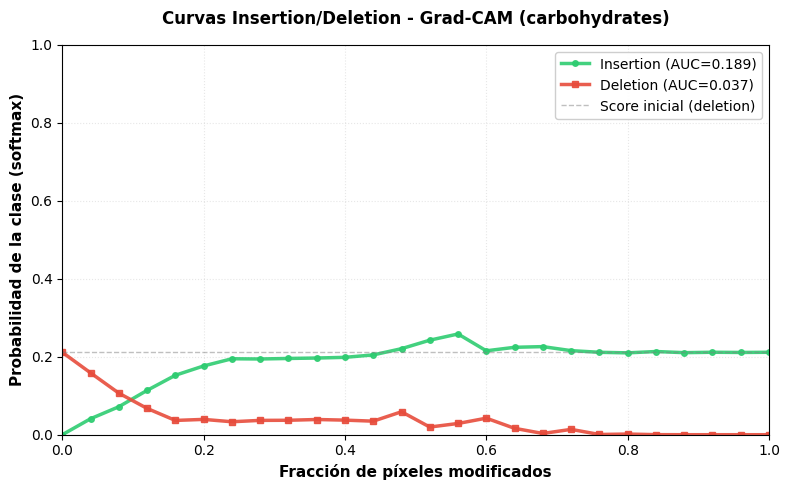

Insertion/Deletion usando Grad-CAM (GradCAM++ removido).

INTERPRETACIÓN DE RESULTADOS:
Se evidencian dos curvas que evalúan la fidelidad del mapa Grad-CAM (AUC Insertion=0.189,
AUC Deletion=0.037). La curva de Insertion (verde) muestra cómo aumenta la
probabilidad de la clase a medida que revelamos progresivamente los píxeles más importantes
según Grad-CAM, comenzando desde una imagen negra (probabilidad cercana a 0). La curva de
Deletion (roja) muestra cómo DISMINUYE la probabilidad al ELIMINAR progresivamente esos
píxeles importantes desde la imagen completa (probabilidad inicial alta). Un mapa fiel debe
exhibir: (1) subida rápida y pronunciada en Insertion (revelar regiones clave aumenta
la confianza rápidamente), y (2) CAÍDA MARCADA en Deletion (eliminar regiones clave
DEGRADA la predicción significativamente). El AUC cuantifica estas tendencias: mayor AUC
en Insertion indica que revelar píxeles importantes aumenta rápidamente la confianza;
menor AUC en Deletion indica que elimina

In [8]:
# Calcular curvas Insertion / Deletion (usar Grad-CAM estándar)
import numpy as np
import torch

def evaluate_insertion_deletion(cam, img_tensor, class_idx, steps=20, mode='insertion'):
    """
    Evaluar fidelidad del mapa CAM mediante inserción o eliminación progresiva de píxeles.
    
    Insertion: comenzar con imagen negra, revelar píxeles ordenados por importancia CAM.
    Deletion: comenzar con imagen completa, eliminar píxeles ordenados por importancia CAM.
    """
    assert mode in {'insertion','deletion'}
    
    # Normalizar CAM a rango [0,1]
    cam_norm = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    flat = cam_norm.flatten()
    
    # Ordenar píxeles por importancia (de mayor a menor)
    order_indices = np.argsort(flat)[::-1].copy()
    order = torch.from_numpy(order_indices)
    
    total_pixels = flat.shape[0]
    step_size = max(1, total_pixels // steps)
    scores = []
    
    base = img_tensor.clone()
    h, w = cam.shape
    
    # Estado inicial según modo
    if mode == 'insertion':
        # Insertion: comenzar con imagen negra
        current = torch.zeros_like(base)
    else:
        # Deletion: comenzar con imagen completa
        current = base.clone()
    
    # Medir score inicial (antes de cualquier modificación)
    with torch.no_grad():
        out = model(current.unsqueeze(0))
        score_init = torch.softmax(out, dim=1)[0, class_idx].mean().item()
    scores.append(score_init)
    
    # Aplicar modificaciones progresivas
    for s in range(1, steps+1):
        start = (s-1)*step_size
        end = min(s*step_size, total_pixels)
        idxs = order[start:end]
        
        for idx in idxs:
            r = int(idx.item() // w)
            c = int(idx.item() % w)
            
            if mode == 'insertion':
                # Insertion: revelar píxeles importantes
                current[:, r, c] = base[:, r, c]
            else:
                # Deletion: eliminar píxeles importantes (poner en negro)
                current[:, r, c] = 0.0
        
        # Medir score tras modificación
        with torch.no_grad():
            out = model(current.unsqueeze(0))
            score = torch.softmax(out, dim=1)[0, class_idx].mean().item()
        scores.append(score)
        
        if end >= total_pixels:
            break
    
    return scores

# Usar Grad-CAM (layer4) como mapa base
_, gradcam_base = compute_cam(model.encoder[7], 'gradcam', sample_img, class_to_visualize, smooth=False)

ins_scores = evaluate_insertion_deletion(gradcam_base, sample_img, class_to_visualize, steps=25, mode='insertion')
del_scores = evaluate_insertion_deletion(gradcam_base, sample_img, class_to_visualize, steps=25, mode='deletion')

# Calcular AUC (área bajo la curva) para métricas cuantitativas
x_axis = np.linspace(0, 1, len(ins_scores))
auc_insertion = np.trapz(ins_scores, x_axis)
auc_deletion = np.trapz(del_scores, x_axis)

# Crear gráfica mejorada
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x_axis, ins_scores, color='#2ecc71', linewidth=2.5, marker='o', markersize=4, 
        label=f'Insertion (AUC={auc_insertion:.3f})', alpha=0.9)
ax.plot(x_axis, del_scores, color='#e74c3c', linewidth=2.5, marker='s', markersize=4, 
        label=f'Deletion (AUC={auc_deletion:.3f})', alpha=0.9)

# Añadir línea de referencia
if len(del_scores) > 0:
    ax.axhline(y=del_scores[0], color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Score inicial (deletion)')

# Configurar ejes y estilo
ax.set_xlabel('Fracción de píxeles modificados', fontsize=11, fontweight='bold')
ax.set_ylabel('Probabilidad de la clase (softmax)', fontsize=11, fontweight='bold')
ax.set_title(f'Curvas Insertion/Deletion - Grad-CAM ({class_names[class_to_visualize]})', 
             fontsize=12, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.legend(loc='best', framealpha=0.95, fontsize=10)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])  # Probabilidades normalizadas entre 0 y 1

plt.tight_layout()
save_fig(f'gradcam_insertion_deletion_{class_names[class_to_visualize]}_sin_gradcampp.png')
plt.show()
print('Insertion/Deletion usando Grad-CAM (GradCAM++ removido).')

print('\n' + '='*80)
print('INTERPRETACIÓN DE RESULTADOS:')
print('='*80)
print(f'Se evidencian dos curvas que evalúan la fidelidad del mapa Grad-CAM (AUC Insertion={auc_insertion:.3f},')
print(f'AUC Deletion={auc_deletion:.3f}). La curva de Insertion (verde) muestra cómo aumenta la')
print('probabilidad de la clase a medida que revelamos progresivamente los píxeles más importantes')
print('según Grad-CAM, comenzando desde una imagen negra (probabilidad cercana a 0). La curva de')
print('Deletion (roja) muestra cómo DISMINUYE la probabilidad al ELIMINAR progresivamente esos')
print('píxeles importantes desde la imagen completa (probabilidad inicial alta). Un mapa fiel debe')
print('exhibir: (1) subida rápida y pronunciada en Insertion (revelar regiones clave aumenta')
print('la confianza rápidamente), y (2) CAÍDA MARCADA en Deletion (eliminar regiones clave')
print('DEGRADA la predicción significativamente). El AUC cuantifica estas tendencias: mayor AUC')
print('en Insertion indica que revelar píxeles importantes aumenta rápidamente la confianza;')
print('menor AUC en Deletion indica que eliminar píxeles importantes degrada rápidamente la')
print('predicción. Esto ocurre porque estamos ordenando píxeles por importancia según el')
print('gradiente: si Grad-CAM identifica correctamente las regiones decisivas, manipularlas')
print('en orden de importancia tiene un impacto fuerte y temprano en la salida del modelo.')
print('Si la curva de Deletion SUBE en lugar de BAJAR, indica que el mapa CAM está identificando')
print('regiones IRRELEVANTES o que el modelo tiene sesgos inesperados.')
print('='*80)


## Sanity check por randomización (Adebayo et al.)
Esta celda verifica que el mapa Grad-CAM dependa de los pesos del modelo:
- Guardar el estado original de `layer4` y calcular un CAM de referencia.
- Reinicializar aleatoriamente los pesos de la capa y recalcular el CAM.
- Medir la degradación mediante MSE entre los mapas original y randomizado.
- Restaurar los pesos originales y visualizar ambos mapas junto con la métrica para el informe.

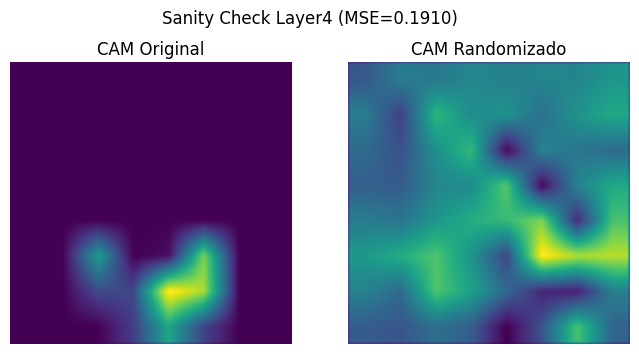

Randomization sanity check completado, MSE: 0.19096648693084717

INTERPRETACIÓN DE RESULTADOS:
Se evidencia una diferencia significativa entre el mapa Grad-CAM original (izquierda)
y el mapa generado tras reinicializar aleatoriamente los pesos de layer4 (derecha).
El MSE (error cuadrático medio) cuantifica esta degradación: valores altos indican
que el mapa original depende fuertemente de los pesos entrenados. El CAM randomizado
suele exhibir patrones incoherentes o ruido, perdiendo la estructura semántica del
original. Esto ocurre porque Grad-CAM calcula gradientes de la salida respecto a las
activaciones de la capa: si los pesos son aleatorios, las activaciones y gradientes
no reflejan características aprendidas, generando mapas sin sentido. Este sanity check
(Adebayo et al., 2018) valida que la explicación no es un artefacto del método, sino
que genuinamente refleja el conocimiento almacenado en los pesos del modelo entrenado.


In [9]:
# Realizar Sanity Check (Randomization Test): reinicializar layer4 y medir degradación del CAM
import copy

# Guardar copia del estado original
def randomization_test(layer, img_tensor, class_idx):
    original_weights = copy.deepcopy(layer.state_dict())
    # Calcular CAM original
    cam_orig, raw_orig = compute_cam(layer, 'gradcam', img_tensor, class_idx)
    # Reinicializar pesos aleatoriamente
    for name, param in layer.named_parameters():
        if 'weight' in name and param.data.dim() >= 2:
            nn.init.normal_(param.data, 0, 0.02)
        elif 'bias' in name:
            nn.init.constant_(param.data, 0.)
    cam_rand, raw_rand = compute_cam(layer, 'gradcam', img_tensor, class_idx)
    # Calcular MSE entre mapas
    mse = ((torch.tensor(raw_orig) - torch.tensor(raw_rand))**2).mean().item()
    # Restaurar estado original
    layer.load_state_dict(original_weights)
    return raw_orig, raw_rand, mse

raw_o, raw_r, mse_val = randomization_test(model.encoder[7], sample_img, class_to_visualize)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(raw_o, cmap='viridis'); plt.title('CAM Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(raw_r, cmap='viridis'); plt.title('CAM Randomizado'); plt.axis('off')
plt.suptitle(f'Sanity Check Layer4 (MSE={mse_val:.4f})')
save_fig('gradcam_sanity_randomization_layer4.png')
plt.show()
print('Randomization sanity check completado, MSE:', mse_val)

print('\n' + '='*80)
print('INTERPRETACIÓN DE RESULTADOS:')
print('='*80)
print('Se evidencia una diferencia significativa entre el mapa Grad-CAM original (izquierda)')
print('y el mapa generado tras reinicializar aleatoriamente los pesos de layer4 (derecha).')
print('El MSE (error cuadrático medio) cuantifica esta degradación: valores altos indican')
print('que el mapa original depende fuertemente de los pesos entrenados. El CAM randomizado')
print('suele exhibir patrones incoherentes o ruido, perdiendo la estructura semántica del')
print('original. Esto ocurre porque Grad-CAM calcula gradientes de la salida respecto a las')
print('activaciones de la capa: si los pesos son aleatorios, las activaciones y gradientes')
print('no reflejan características aprendidas, generando mapas sin sentido. Este sanity check')
print('(Adebayo et al., 2018) valida que la explicación no es un artefacto del método, sino')
print('que genuinamente refleja el conocimiento almacenado en los pesos del modelo entrenado.')
print('='*80)

## Promedio de Grad-CAM por clase (patrón global)
Esta celda resume la atención del modelo por clase a lo largo de varias muestras:
- Calcular Grad-CAM (capa profunda) para las primeras `N` imágenes del dataset.
- Apilar mapas por clase y promediar para obtener un patrón global de atención.
- Visualizar los mapas promedio por clase para detectar sesgos o estructuras recurrentes.
- Guardar las visualizaciones para documentación y análisis comparativo.

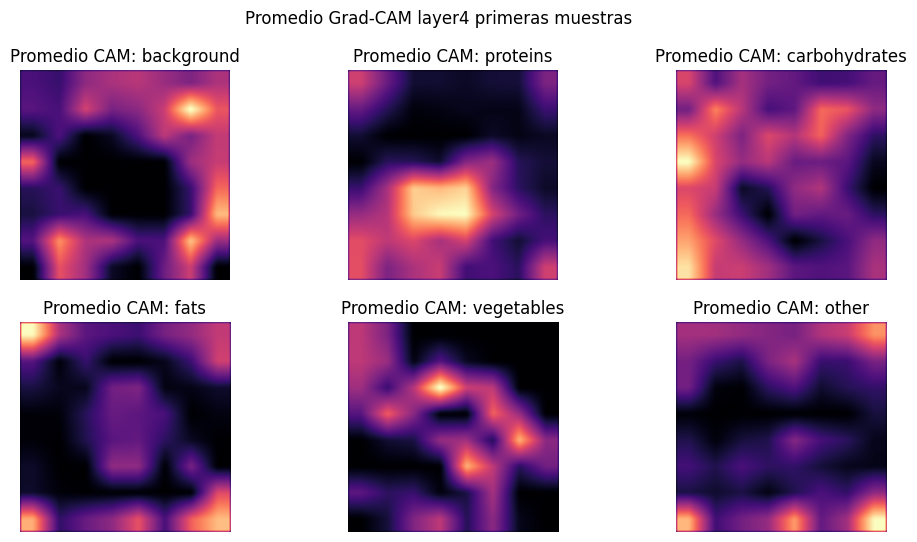

Promedios CAM por clase generados.

INTERPRETACIÓN DE RESULTADOS:
Se evidencian patrones de atención promedio del modelo para cada macro-clase a través
de múltiples imágenes del dataset. Estos mapas agregados revelan sesgos espaciales
sistemáticos: por ejemplo, si el modelo tiende a buscar ciertas clases en regiones
centrales o periféricas de las imágenes. Patrones concentrados en el centro sugieren
sesgo de composición fotográfica (objetos principales suelen estar centrados). Mapas
uniformes indican que el modelo ha aprendido características invariantes a la posición.
Esto ocurre porque al promediar Grad-CAM sobre varias muestras, se cancelan las
variaciones específicas de cada imagen y emergen las tendencias globales de atención
del modelo. Estos promedios son útiles para detectar sesgos en el entrenamiento,
validar que el modelo no dependa excesivamente de atajos espaciales (shortcuts), y
verificar la robustez de las representaciones aprendidas para cada macronutriente.


In [10]:
# Promediar CAM por clase sobre primeras N muestras para patrón global
N = min(10, len(dataset))
class_avg = {c: [] for c in range(6)}
for idx in range(N):
    img, _ = dataset[idx]
    img = img.to(device)
    for c in range(6):
        _, raw = compute_cam(model.encoder[7], 'gradcam', img, c)
        class_avg[c].append(raw)

avg_maps = {}
plt.figure(figsize=(12,6))
for c in range(6):
    arr = np.stack(class_avg[c])
    avg = arr.mean(axis=0)
    avg_maps[c] = avg
    plt.subplot(2,3,c+1)
    plt.imshow(avg, cmap='magma')
    plt.title(f'Promedio CAM: {class_names[c]}')
    plt.axis('off')
plt.suptitle('Promedio Grad-CAM layer4 primeras muestras')
save_fig('gradcam_average_per_class.png')
plt.show()
print('Promedios CAM por clase generados.')

print('\n' + '='*80)
print('INTERPRETACIÓN DE RESULTADOS:')
print('='*80)
print('Se evidencian patrones de atención promedio del modelo para cada macro-clase a través')
print('de múltiples imágenes del dataset. Estos mapas agregados revelan sesgos espaciales')
print('sistemáticos: por ejemplo, si el modelo tiende a buscar ciertas clases en regiones')
print('centrales o periféricas de las imágenes. Patrones concentrados en el centro sugieren')
print('sesgo de composición fotográfica (objetos principales suelen estar centrados). Mapas')
print('uniformes indican que el modelo ha aprendido características invariantes a la posición.')
print('Esto ocurre porque al promediar Grad-CAM sobre varias muestras, se cancelan las')
print('variaciones específicas de cada imagen y emergen las tendencias globales de atención')
print('del modelo. Estos promedios son útiles para detectar sesgos en el entrenamiento,')
print('validar que el modelo no dependa excesivamente de atajos espaciales (shortcuts), y')
print('verificar la robustez de las representaciones aprendidas para cada macronutriente.')
print('='*80)